WTI 常稱為美國原油、西德州原油或紐約原油，WTI是West Texas Intermediate 的簡稱，代表西德州中級原油 (West Texas Intermediate)，偶爾稱為德州輕甜原油 (Texas Light Sweet)，它是大宗商品交易中核心的石油基準。

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device)) 

Using cuda device


In [ ]:
!gdown --id '11r8ZxjlDFy3I0VlT5JVYPxWq7sRYMnSl' --output orgdata.csv

!ls 
# 使用顯卡型號
# K80 < P4 < T4 < P100 <= T4(fp16) < V100
!nvidia-smi

Downloading...
From: https://drive.google.com/uc?id=11r8ZxjlDFy3I0VlT5JVYPxWq7sRYMnSl
To: /content/orgdata.csv
100% 132k/132k [00:00<00:00, 49.7MB/s]
orgdata.csv  sample_data
Mon Nov  8 02:34:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                 

# 前處理

In [ ]:
import random
import numpy as np

def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(36544)

In [ ]:
path = 'orgdata.csv'
features = pd.read_csv(path)
features

,Unnamed: 0,日期,標普500,西德州,布蘭特原油,原油庫存,MSCI能源ETF價格,世界能源指數,VIX恐慌指数
0,7257,2013/10/25,1759.77,97.40,105.70,97.849998,25.000000,269.49,13.09
1,7258,2013/10/28,1762.11,98.74,108.29,98.680000,25.040001,269.36,13.31
2,7259,2013/10/29,1771.95,98.29,108.04,98.199997,25.219999,271.72,13.41
3,7260,2013/10/30,1763.31,96.81,108.41,96.769997,25.059999,271.09,13.65
4,7261,2013/10/31,1756.54,96.29,107.53,96.379997,25.000000,269.36,13.75
...,...,...,...,...,...,...,...,...,...
1863,9209,2021/4/20,4134.94,62.61,65.34,62.439999,12.680000,151.47,18.68
1864,9210,2021/4/21,4173.42,61.34,64.02,61.349998,12.870000,153.06,17.50
1865,9211,2021/4/22,4134.98,61.45,65.07,61.430000,12.700000,151.42,18.71
1866,9212,2021/4/23,4180.17,62.18,65.75,62.139999,12.840000,152.06,17.33


# 檢查是否有nan 並解決

In [ ]:
print(np.any(np.isnan(features['原油庫存'])))
print(np.any(np.isnan(features['MSCI能源ETF價格'])))
print(np.any(np.isnan(features['世界能源指數'])))
print(np.any(np.isnan(features['VIX恐慌指数'])))

True
False
False
False


In [ ]:
index = 0
for i in range(len(features['原油庫存'])):
  if np.any(np.isnan(features['原油庫存'].iloc[i])) == True:
    features['原油庫存'].iloc[i] = features['原油庫存'].iloc[i-1]
    index += 1

In [ ]:
print(np.any(np.isnan(features['原油庫存'])))
print(np.any(np.isnan(features['MSCI能源ETF價格'])))
print(np.any(np.isnan(features['世界能源指數'])))
print(np.any(np.isnan(features['VIX恐慌指数'])))


False
False
False
False


In [ ]:
# features.drop(axis=0, columns=[features.columns[0],features.columns[2],features.columns[4],features.columns[6],features.columns[7],features.columns[8]], inplace=True)
features.drop(axis=0, columns=[features.columns[0]], inplace=True)
features

,日期,標普500,西德州,布蘭特原油,原油庫存,MSCI能源ETF價格,世界能源指數,VIX恐慌指数
0,2013/10/25,1759.77,97.40,105.70,97.849998,25.000000,269.49,13.09
1,2013/10/28,1762.11,98.74,108.29,98.680000,25.040001,269.36,13.31
2,2013/10/29,1771.95,98.29,108.04,98.199997,25.219999,271.72,13.41
3,2013/10/30,1763.31,96.81,108.41,96.769997,25.059999,271.09,13.65
4,2013/10/31,1756.54,96.29,107.53,96.379997,25.000000,269.36,13.75
...,...,...,...,...,...,...,...,...
1863,2021/4/20,4134.94,62.61,65.34,62.439999,12.680000,151.47,18.68
1864,2021/4/21,4173.42,61.34,64.02,61.349998,12.870000,153.06,17.50
1865,2021/4/22,4134.98,61.45,65.07,61.430000,12.700000,151.42,18.71
1866,2021/4/23,4180.17,62.18,65.75,62.139999,12.840000,152.06,17.33


# 時間轉換為datetime格式

In [ ]:

date = list(features['日期'])
date_form = []

for i in date:    
    i = i.replace('/','-')
    date_form.append(i)
date_form[:10]

['2013-10-25',
 '2013-10-28',
 '2013-10-29',
 '2013-10-30',
 '2013-10-31',
 '2013-11-1',
 '2013-11-4',
 '2013-11-5',
 '2013-11-6',
 '2013-11-7']

In [ ]:
# date = datetime格式

import datetime
dates = [datetime.datetime.strptime(x, '%Y-%m-%d') for x in date_form]
dates[:5]

[datetime.datetime(2013, 10, 25, 0, 0),
 datetime.datetime(2013, 10, 28, 0, 0),
 datetime.datetime(2013, 10, 29, 0, 0),
 datetime.datetime(2013, 10, 30, 0, 0),
 datetime.datetime(2013, 10, 31, 0, 0)]

In [ ]:
features.set_index("日期")

,標普500,西德州,布蘭特原油,原油庫存,MSCI能源ETF價格,世界能源指數,VIX恐慌指数
日期,,,,,,,
2013/10/25,1759.77,97.40,105.70,97.849998,25.000000,269.49,13.09
2013/10/28,1762.11,98.74,108.29,98.680000,25.040001,269.36,13.31
2013/10/29,1771.95,98.29,108.04,98.199997,25.219999,271.72,13.41
2013/10/30,1763.31,96.81,108.41,96.769997,25.059999,271.09,13.65
2013/10/31,1756.54,96.29,107.53,96.379997,25.000000,269.36,13.75
...,...,...,...,...,...,...,...
2021/4/20,4134.94,62.61,65.34,62.439999,12.680000,151.47,18.68
2021/4/21,4173.42,61.34,64.02,61.349998,12.870000,153.06,17.50
2021/4/22,4134.98,61.45,65.07,61.430000,12.700000,151.42,18.71


Text(0.5, 1.0, 'VIX Index')

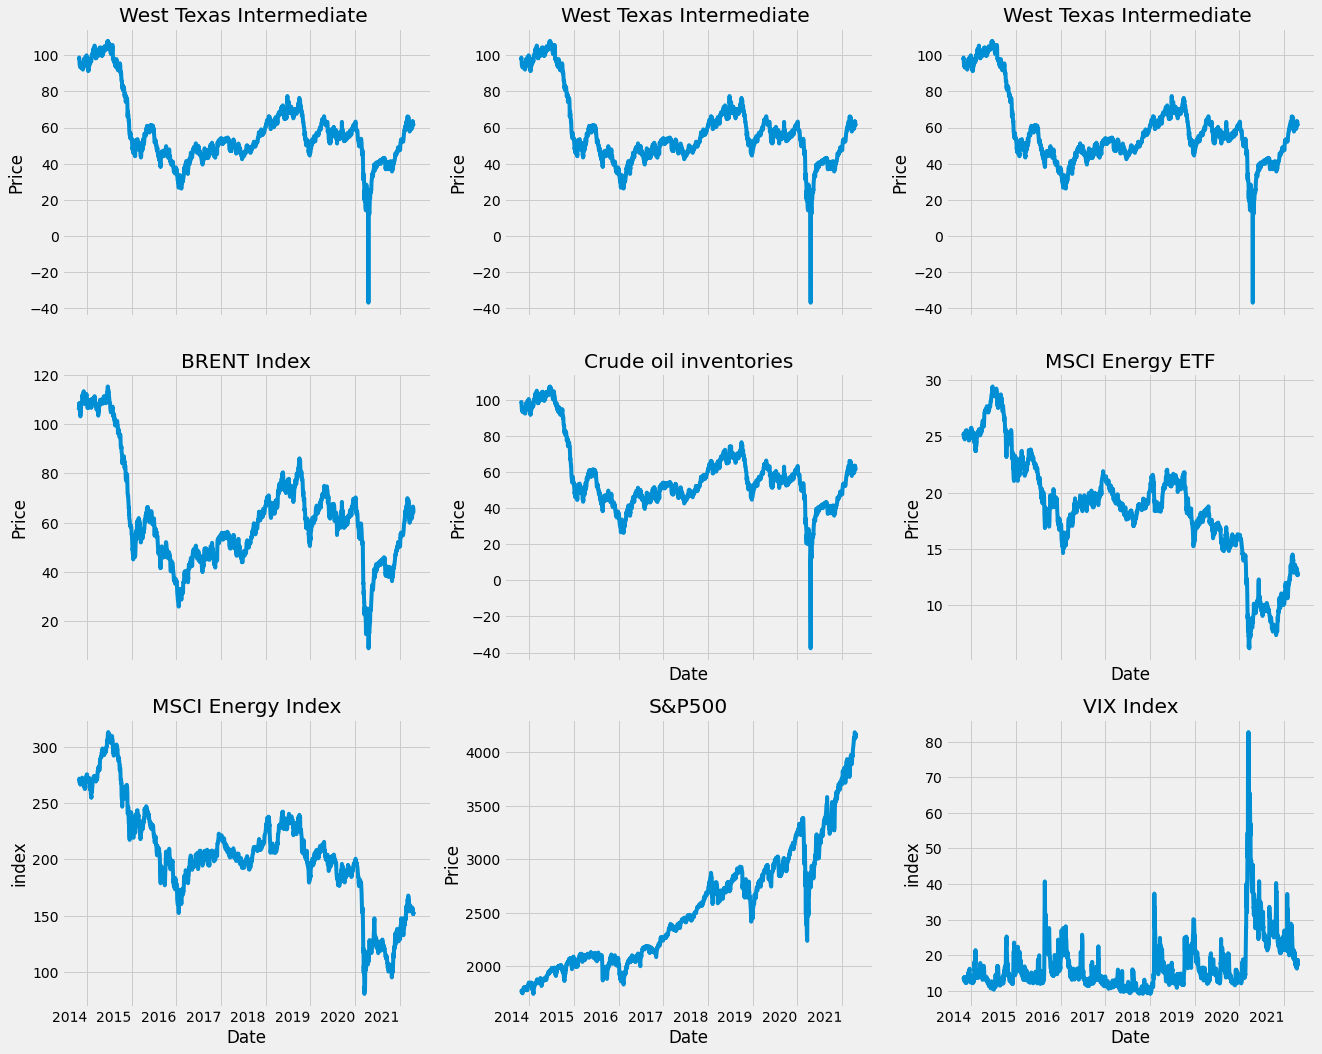

In [ ]:
# 指定風格
plt.style.use('fivethirtyeight')

# 布局
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize = (20,20))
fig.autofmt_xdate(rotation = 0.5)

ax1.plot(dates, features['西德州'])
ax1.set_xlabel(''); ax1.set_ylabel('Price'); ax1.set_title('West Texas Intermediate ')


ax2.plot(dates, features['西德州'])
ax2.set_xlabel(''); ax2.set_ylabel('Price'); ax2.set_title('West Texas Intermediate ')

ax3.plot(dates, features['西德州'])
ax3.set_xlabel(''); ax3.set_ylabel('Price'); ax3.set_title('West Texas Intermediate ')

ax4.plot(dates, features['布蘭特原油'])
ax4.set_xlabel(''); ax4.set_ylabel('Price'); ax4.set_title('BRENT Index')    # 布蘭特原油指數


ax5.plot(dates, features['原油庫存'])
ax5.set_xlabel('Date'); ax5.set_ylabel('Price'); ax5.set_title('Crude oil inventories')  # 美國原油庫存

ax6.plot(dates, features['MSCI能源ETF價格'])
ax6.set_xlabel('Date'); ax6.set_ylabel('Price'); ax6.set_title('MSCI Energy ETF')    # MSCI能源ETF價格

ax7.plot(dates, features['世界能源指數'])
ax7.set_xlabel('Date'); ax7.set_ylabel('index'); ax7.set_title('MSCI Energy Index')  # 世界能源指數

ax8.plot(dates, features['標普500'])
ax8.set_xlabel('Date'); ax8.set_ylabel('Price'); ax8.set_title('S&P500')  # S&P500
 
ax9.plot(dates, features['VIX恐慌指数'])
ax9.set_xlabel('Date'); ax9.set_ylabel('index'); ax9.set_title('VIX Index') # VIX恐慌指数
 
# plt.tight_layout(pad=2)

In [ ]:
features_process = features.iloc[:,1:]
features_process


,標普500,西德州,布蘭特原油,原油庫存,MSCI能源ETF價格,世界能源指數,VIX恐慌指数
0,1759.77,97.40,105.70,97.849998,25.000000,269.49,13.09
1,1762.11,98.74,108.29,98.680000,25.040001,269.36,13.31
2,1771.95,98.29,108.04,98.199997,25.219999,271.72,13.41
3,1763.31,96.81,108.41,96.769997,25.059999,271.09,13.65
4,1756.54,96.29,107.53,96.379997,25.000000,269.36,13.75
...,...,...,...,...,...,...,...
1863,4134.94,62.61,65.34,62.439999,12.680000,151.47,18.68
1864,4173.42,61.34,64.02,61.349998,12.870000,153.06,17.50
1865,4134.98,61.45,65.07,61.430000,12.700000,151.42,18.71
1866,4180.17,62.18,65.75,62.139999,12.840000,152.06,17.33


In [ ]:
df_features = features_process
df_features1 = df_features[['西德州']]
df_features2 = df_features[['布蘭特原油']]
df_features3 = df_features[['原油庫存']]
df_features4 = df_features[['標普500']]
df_features5 = df_features[['MSCI能源ETF價格']]
df_features6 = df_features[['世界能源指數']]
df_features7 = df_features[['VIX恐慌指数']]

# 標準化每個features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_features1 = df_features1.fillna(method = 'ffill')
df_features2 = df_features2.fillna(method = 'ffill')
df_features3 = df_features3.fillna(method = 'ffill')
df_features4 = df_features4.fillna(method = 'ffill')
df_features5 = df_features5.fillna(method = 'ffill')
df_features6 = df_features6.fillna(method = 'ffill')
df_features7 = df_features7.fillna(method = 'ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))

scaler1 = MinMaxScaler(feature_range=(-1, 1))
df_features['西德州'] = scaler1.fit_transform(df_features['西德州'].values.reshape(-1,1))

scaler_2 = MinMaxScaler(feature_range=(-1, 1))
df_features['布蘭特原油'] = scaler_2.fit_transform(df_features['布蘭特原油'].values.reshape(-1,1))

scaler_3 = MinMaxScaler(feature_range=(-1, 1))
df_features['原油庫存'] = scaler_3.fit_transform(df_features['原油庫存'].values.reshape(-1,1))

scaler_4 = MinMaxScaler(feature_range=(-1, 1))
df_features['標普500'] = scaler_4.fit_transform(df_features['標普500'].values.reshape(-1,1))

scaler_5 = MinMaxScaler(feature_range=(-1, 1))
df_features['MSCI能源ETF價格'] = scaler_5.fit_transform(df_features['MSCI能源ETF價格'].values.reshape(-1,1))

scaler_6 = MinMaxScaler(feature_range=(-1, 1))
df_features['世界能源指數'] = scaler_6.fit_transform(df_features['世界能源指數'].values.reshape(-1,1))

scaler_7 = MinMaxScaler(feature_range=(-1, 1))
df_features['VIX恐慌指数'] = scaler_7.fit_transform(df_features['VIX恐慌指数'].values.reshape(-1,1))

# 變數選擇


In [ ]:
  # 標普500(1)	西德州(2)	布蘭特原油(3)	原油庫存(4)	MSCI能源ETF價格(5)	世界能源指數(6)	VIX恐慌指数(7)

# df_features.drop(axis=0, columns=[features.columns[1], features.columns[3], features.columns[4], features.columns[5], features.columns[6], features.columns[7]], inplace=True) 
# df_features.drop(axis=0, columns=[features.columns[3], features.columns[6]], inplace=True)

# divide Training and validation 
# Input shape
3D tensor with shape (batch_size, timesteps, input_dim).
同LSTM的batch_first

timesteps can be None. This can be useful if each sequence is of a different length: Multiple Length Sequence Example

# 設定Hyperparameter

In [ ]:
from torch import optim
import torch as t

#-------for LSTM formula--------------#
look_back_windows = 5 # 用前幾天的資料預測下一天 同look_back

#-------for networks--------------#
kernel_size = 2
dropout = 0.2

#-------for training--------------#
learning_rate = 0.001
epoch = 1000

In [ ]:
def load_data(stock, n_timestamp, true, dates):
  
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - n_timestamp): 
        data.append(data_raw[index: index + n_timestamp])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    train_set_size_list = train_set_size + n_timestamp

    train_dates = dates[:train_set_size]
    test_dates = dates[train_set_size_list:]
    train_true = true[:train_set_size]
    test_true = true[train_set_size_list:]
    
    x_all = data[:,:-1,:]

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_all, x_train, y_train, x_test, y_test, data, train_true, test_true, train_dates, test_dates]


x_all, x_train, y_train, x_test, y_test, data, train_true, test_true, train_dates, test_dates = load_data(df_features, look_back_windows, df_features1, dates)
print('x_all.shape = ',x_all.shape)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
print('train_true.shape = ',train_true.shape)
print('test_true.shape = ',test_true.shape)
print('train_dates.shape = ',len(train_dates))
print('test_dates.shape = ',len(test_dates))
print('data for wholes = ', data.shape)

x_all.shape =  (1863, 4, 7)
x_train.shape =  (1490, 4, 7)
y_train.shape =  (1490, 7)
x_test.shape =  (373, 4, 7)
y_test.shape =  (373, 7)
train_true.shape =  (1490, 1)
test_true.shape =  (373, 1)
train_dates.shape =  1490
test_dates.shape =  373
data for wholes =  (1863, 5, 7)


In [ ]:
x_all, x_train, x_valid, y_train, y_valid = np.array(x_all), np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)
x_all, x_train, x_valid, y_train, y_valid = torch.tensor(x_all, dtype = torch.float), torch.tensor(x_train, dtype = torch.float), torch.tensor(x_valid, dtype = torch.float), torch.tensor(y_train, dtype = torch.float), torch.tensor(y_valid, dtype = torch.float)

print(x_train.shape,type(x_train))
print(y_train.shape,type(y_train))
print(x_valid.shape,type(x_valid))
print(y_valid.shape,type(y_valid))
print(x_all.shape,type(x_all))

torch.Size([1490, 4, 7]) <class 'torch.Tensor'>
torch.Size([1490, 7]) <class 'torch.Tensor'>
torch.Size([373, 4, 7]) <class 'torch.Tensor'>
torch.Size([373, 7]) <class 'torch.Tensor'>
torch.Size([1863, 4, 7]) <class 'torch.Tensor'>


In [ ]:
x_train = x_train.to(device)
y_train = y_train.to(device)
x_valid = x_valid.to(device)
y_valid = y_valid.to(device)

# 導入TCN模型架構

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        """
        其實這就是一個裁剪的模塊，裁剪多出來的padding
        """
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        """
        相當於一個Residual block

        :param n_inputs: int, 輸入通道數
        :param n_outputs: int, 輸出通道數
        :param kernel_size: int, 卷積核尺寸
        :param stride: int, 步長，一般爲1
        :param dilation: int, 膨脹係數
        :param padding: int, 填充係數
        :param dropout: float, dropout比率
        """
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 經過conv1，輸出的size其實是(Batch, input_channel, seq_len + padding)
        self.chomp1 = Chomp1d(padding)  # 裁剪掉多出來的padding部分，維持輸出時間步爲seq_len
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)  #  裁剪掉多出來的padding部分，維持輸出時間步爲seq_len
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        """
        參數初始化

        :return:
        """
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        """
        :param x: size of (Batch, input_channel, seq_len)
        :return:
        """
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
  # ref: https://www.twblogs.net/a/5d6dc709bd9eee541c33c0b2
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        """
        TCN，目前paper給出的TCN結構很好的支持每個時刻爲一個數的情況，即sequence結構，
        對於每個時刻爲一個向量這種一維結構，勉強可以把向量拆成若干該時刻的輸入通道，
        對於每個時刻爲一個矩陣或更高維圖像的情況，就不太好辦。

        :param num_inputs: int， 輸入通道數
        :param num_channels: list，每層的hidden_channel數，例如[25,25,25,25]表示有4個隱層，每層hidden_channel數爲25
        :param kernel_size: int, 卷積核尺寸
        :param dropout: float, drop_out比率
        """
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i   # 膨脹係數：1，2，4，8……
            in_channels = num_inputs if i == 0 else num_channels[i-1]  # 確定每一層的輸入通道數
            out_channels = num_channels[i]  # 確定每一層的輸出通道數
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        """
        輸入x的結構不同於RNN，一般RNN的size爲(Batch, seq_len, channels)或者(seq_len, Batch, channels)，
        這裏把seq_len放在channels後面，把所有時間步的數據拼起來，當做Conv1d的輸入尺寸，實現卷積跨時間步的操作，
        很巧妙的設計。
        
        :param x: size of (Batch, input_channel, seq_len)
        :return: size of (Batch, output_channel, seq_len)
        """
        return self.network(x)

# 建立模型

In [ ]:
class TCNModel(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=kernel_size, dropout=dropout):
        super(TCNModel, self).__init__()
        self.tcn = TemporalConvNet(
            num_inputs, num_channels, kernel_size=kernel_size, dropout=dropout)  #(num_inputs神經元, num_channels通道, kernel_size, dropout)
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        return self.decoder(self.dropout(self.tcn(x)[:, :, -1]))

# 定義RMSE

In [ ]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

# 訓練model的參數定義

In [ ]:
num_channels = [x_train.shape[2], x_train.shape[2], x_train.shape[2]]  # num_channels: 必須以list包裝，num_channels每層的hidden_channel數，例如[25,25,25,25]表示有4個隱層，每層hidden_channel數爲25
num_inputs = look_back_windows-1

model = TCNModel(num_inputs, num_channels, kernel_size=kernel_size, dropout=dropout).to(device) # num_inputs = look_back_windows-1, num_channels = 通道數
#-------for optimizer and evaluation--------------#
opt = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = RMSELoss()


In [ ]:
def train(x_train, y_train, hist):
    model.train()
    # look_back = look_back_windows-1
    pred = model(x_train)
    loss = loss_func(pred, y_train.to(device))

    # if t % 10 == 0 and t !=0:
    #     # print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    # Zero out gradient, else they will accumulate between epochs
    opt.zero_grad()
    # Backward pass
    loss.backward()
    # Update parameters
    opt.step()
    return pred, loss, hist[t]

In [ ]:
def test(x_test, y_test, hist_val):
    model.eval()  # 關閉batchnormaliztion和dropout
    look_back = look_back_windows-1
    predict_val = model(x_test)

    loss_val = loss_func(predict_val , y_test)
    hist_val[t] = loss.item()

    return predict_val, loss_val, hist_val[t]

In [ ]:
# Train model
#####################  Loss 0.3533

hist = np.zeros(epoch)
hist_val = np.zeros(epoch)

# Number of steps to unroll


t = 0
for t in range(epoch):
  pred, loss, hist[t] = train(x_train, y_train, hist)
  predict_val, loss_val, hist_val[t] = test(x_valid, y_valid, hist_val)
  t += 1
  if (t) % 10 == 0:
    print(f'epoch:{t}  -------  loss:{loss.item():.4f}  -------  valid_loss:{loss_val.item():.4f}')  

model.train(False) # 關閉訓練模式

epoch:10  -------  loss:0.5388  -------  valid_loss:0.4552
epoch:20  -------  loss:0.5300  -------  valid_loss:0.4543


KeyboardInterrupt: ignored

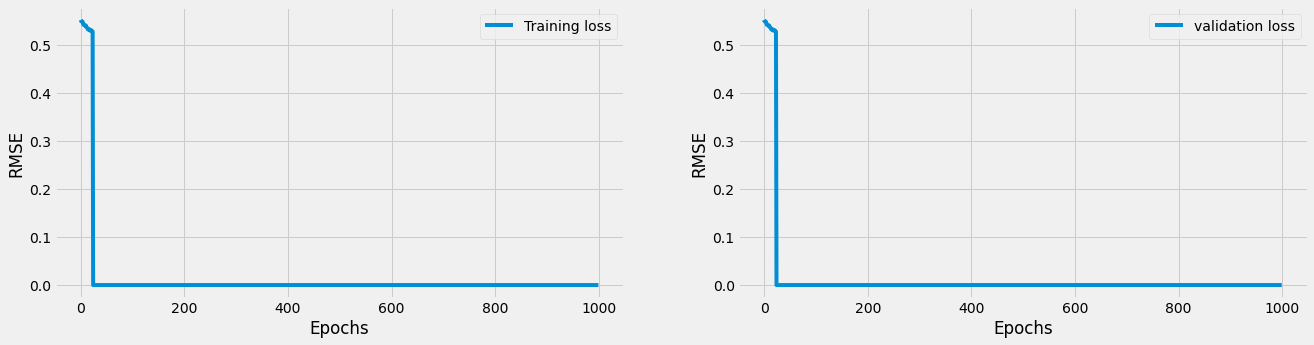

In [ ]:
plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.ylabel("RMSE")
plt.xlabel("Epochs")
     
plt.plot(hist, label="Training loss")
plt.legend()

plt.subplot(1,2,2)     
plt.ylabel("RMSE")
plt.xlabel("Epochs")
plt.plot(hist_val, label="validation loss")
plt.legend()

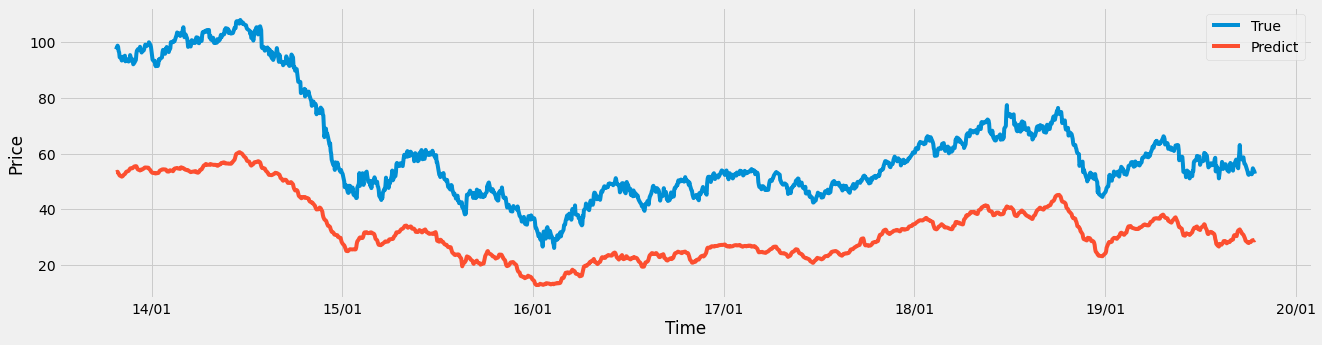

In [ ]:
# Training data 訓練結果

pred = model(x_train)
plt.subplots(figsize=(20,5))
plt.ylabel("Price")
plt.xlabel("Time")
pred = scaler1.inverse_transform(pred.detach().cpu().numpy()) #去除Tensor中的Cuda
pred_list = [] #pred to list
for i in pred:
  pred_list.append(i[0])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y/%m')) #設定橫軸格式
plt.plot(train_dates,train_true, label="True")
plt.plot(train_dates,pred_list, label="Predict")

plt.legend()

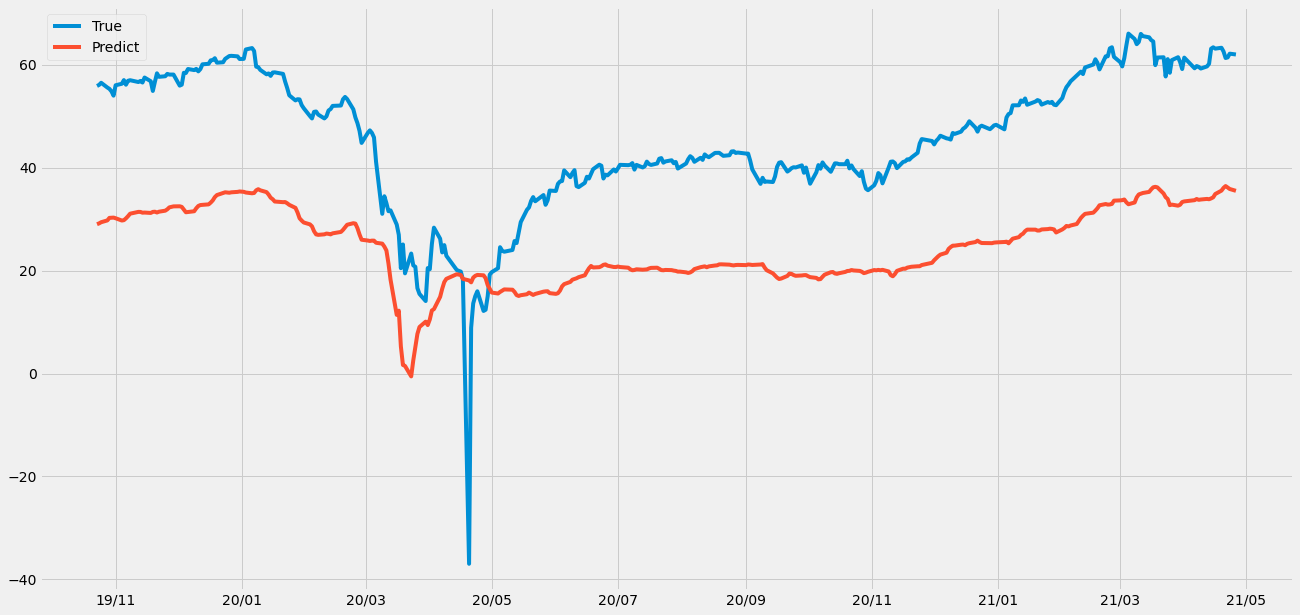

In [ ]:
# Testing data訓練結果
plt.subplots(figsize=(20,10))
pred = model(x_valid)
pred = scaler1.inverse_transform(pred.detach().cpu().numpy())
pred_list = [] #pred to list
for i in pred:
  pred_list.append(i[0])
  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))
plt.plot(test_dates, test_true, label="True")
plt.plot(test_dates, pred_list, label="Predict")
plt.legend()

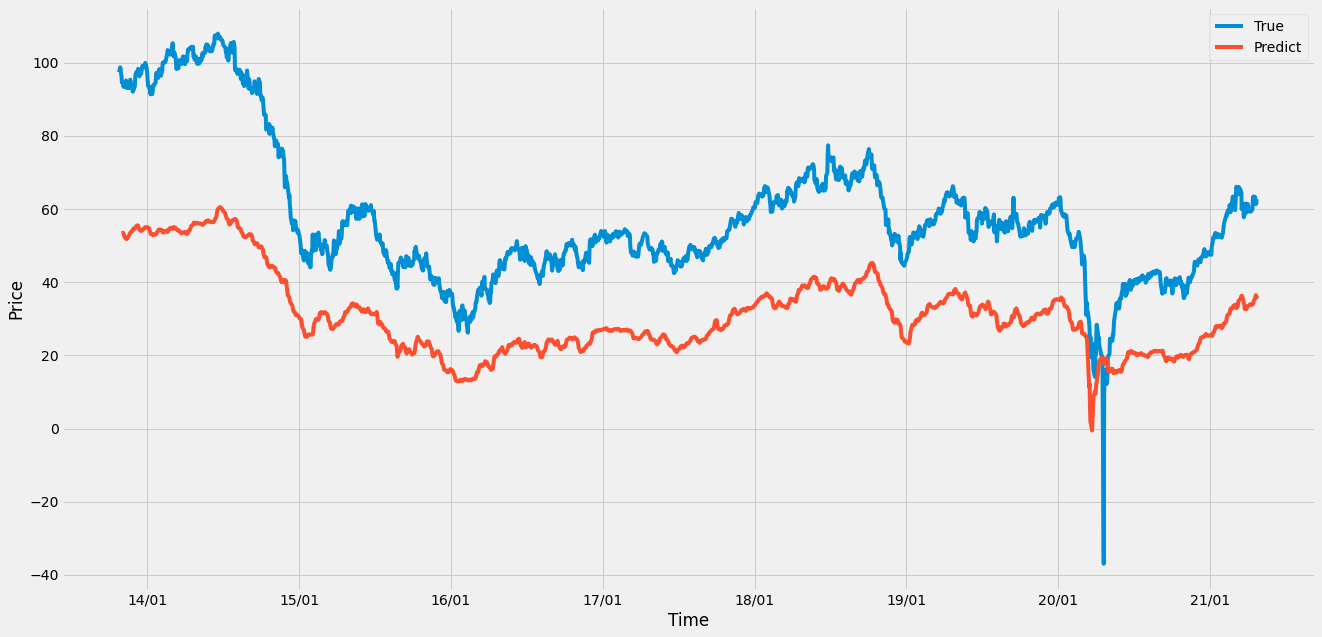

In [ ]:
# 全期訓練結果

plt.subplots(figsize=(20,10))
data = torch.tensor(data, dtype = torch.float)

pred = model(x_all.to(device))
plt.ylabel("Price")
plt.xlabel("Time")
pred = scaler1.inverse_transform(pred.detach().cpu().numpy())

pred_list = [] #pred to list
for i in pred:
  pred_list.append(i[0])

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y/%m'))

plt.plot(dates, df_features1, label="True")

plt.plot(dates[look_back_windows:], pred_list,  label="Predict")

plt.legend()